# Assignment 2

Submitted by Wanzhen(Krystal) Lin.

In this assigment, we will work with the *Adult* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult). Extract the data files into the subdirectory: `../data/adult/` (relative to `./src/`).

## Variable Description

There are several files that you will get in the download archive. We will only use one file: `adult.data`. The file is comma-separated, does not contains headers, and the variable specification is below.


|Variable Name |Role |Type |Demographic |Description |Units |Missing Values|
|--------------|-----|-----|------------|------------|------|--------------|
|age |Feature |Integer |Age |N/A | |no|
|workclass |Feature |Categorical |Income |Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. | |yes|
|fnlwgt |Feature |Integer | | | |no|
|education |Feature |Categorical |Education Level |Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. | |no|
|education-num |Feature |Integer |Education Level | | |no|
|marital-status |Feature |Categorical |Other |Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. | |no|
|occupation |Feature |Categorical |Other |Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. | |yes|
|relationship |Feature |Categorical |Other |Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. | |no|
|race |Feature |Categorical |Race |White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. | |no|
|sex |Feature |Binary |Sex |Female, Male. | |no|
|capital-gain |Feature |Integer | | | |no|
|capital-loss |Feature |Integer | | | |no|
|hours-per-week |Feature |Integer | | | |no|
|native-country |Feature |Categorical |Other |United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. | |yes|
|income |Target |Binary |Income |>50K, <=50K. | |no|


## Objective

The objective of this assignment is to construct a preprocessing and model pipeline to predict the variable `income`. We will evaluate this pipeline using cross-validation.

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [67]:
# Define columns and load data

import pandas as pd
columns = [
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num', 
    'marital-status',
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'capital-gain', 
    'capital-loss', 
    'hours-per-week',
    'native-country', 
    'income'
]

adult_dt = (pd.read_csv('../data/adult/adult.data', header = None, names = columns)
              .assign(income = lambda x: (x.income.str.strip() == '>50K')*1))

In [68]:
adult_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


# Get X and Y

Create the features data frame and target data:

+ Create a dataframe `X` that holds the features (all columns that are not `income`).
+ Create a dataframe `Y` that holds the target data (`income`).
+ From `X` and `Y`, obtain the training and testing data sets:

    - Use a train-test split of 70-30%. 
    - Set the random state of the splitting function to 42.

In [69]:
from sklearn.model_selection import train_test_split, cross_validate

In [70]:
# splliting the dataset into training and testing sets

X = adult_dt.drop(columns=['income'])
Y = adult_dt['income']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.3, random_state = 42)

## Random States

Please comment: 

+ What is the [random state](https://scikit-learn.org/stable/glossary.html#term-random_state) of the [splitting function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)? 
+ Why is it [useful](https://en.wikipedia.org/wiki/Reproducibility)?

##### Answer:
* A random_state parameter of the splitting function controls the shuffling applied to the data before it is split into training and test sets. 
* A Random_state is useful because it ensures that the splits we generate are reproducible. Every time we run codes with the same random_state, we will get the exact same split. This is crucial for experiments' reproducibility or when debugging.

# Preprocessing

Create a [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) that treats the features as follows:

- Numerical variables

    * Apply [KNN-based imputation for completing missing values](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html):
        
        + Consider the 7 nearest neighbours.
        + Weight each neighbour by the inverse of its distance, causing closer neigbours to have more influence than more distant ones.
    * [Scale features using statistics that are robust to outliers](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler).

- Categorical variables: 
    
    * Apply a [simple imputation strategy](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer):

        + Use the most frequent value to complete missing values, also called the *mode*.

    * Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):
        
        + Handle unknown labels if they exist.
        + Drop one column for binary variables.
    
    
The column transformer should look like this:

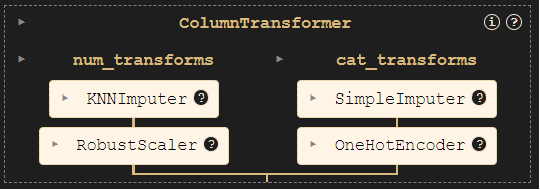



In [71]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, balanced_accuracy_score


In [72]:
adult_dt.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [73]:
adult_dt.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int64
dtype: object

In [74]:
# Preprocessing pipelines

# define numerical columns
num_cols = [
    'age',
    'fnlwgt',
    'education-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
]

# define categorical columns
cat_cols = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
]

In [75]:
# create pipeline for numerical variables

pipe_num = Pipeline(
    steps = [
        ('imputation', KNNImputer(n_neighbors=7)),
        ('standardization', RobustScaler())
    ])
pipe_num

Pipeline(steps=[('imputation', KNNImputer(n_neighbors=7)),
                ('standardization', RobustScaler())])

In [76]:
# create pipeline for categorical variables

pipe_cat = Pipeline(
    steps = [
        ('imputation', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'if_binary'))
    ]
)
pipe_cat

Pipeline(steps=[('imputation', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

In [77]:
# create ColumnTransformer for preprocessing

transformer = ColumnTransformer(
    transformers=[
        ('num_transforms', pipe_num, num_cols), # apply num_transforms to numerical variables
        ('cat_transforms', pipe_cat, cat_cols ) # apply cat_transforms to categorical variables
    ]
)
transformer

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('imputation',
                                                  KNNImputer(n_neighbors=7)),
                                                 ('standardization',
                                                  RobustScaler())]),
                                 ['age', 'fnlwgt', 'education-num',
                                  'capital-gain', 'capital-loss',
                                  'hours-per-week']),
                                ('cat_transforms',
                                 Pipeline(steps=[('imputation',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race', 'sex',
                                  'native-country'])])

## Model Pipeline

Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `classifier` and assign a [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to it.

The pipeline looks like this:

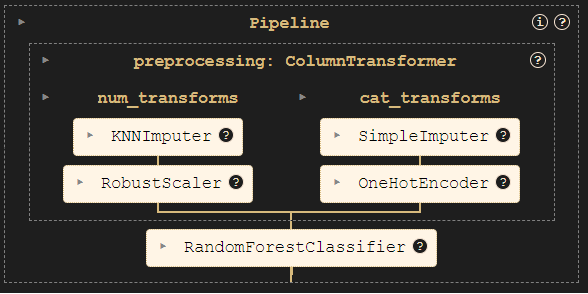

In [78]:
# create a model pipeline: apply ColumnTransformer to split and then preprocess variables, finaly send to classifiers

pipe = Pipeline(
    [
        ('preprocessing',transformer),
        ('classifier', RandomForestClassifier())
    ]
)

# fit the pipeline before making any predictions or evaluations on both training and testing datasets

pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('imputation',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('standardization',
                                                                   RobustScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', RandomForestClassifier())])

# Cross-Validation

Evaluate the model pipeline using [`cross_validate()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html):

+ Measure the following [preformance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values): negative log loss, ROC AUC, accuracy, and balanced accuracy.
+ Report the training and validation results. 
+ Use five folds.


In [79]:
# performance metrics

scoring = ['neg_log_loss', 'roc_auc', 'accuracy', 'balanced_accuracy']

Display the fold-level results as a pandas data frame and sorted by negative log loss of the test (validation) set.

In [ ]:
# use 5 folds

dict = cross_validate(pipe, 
                      X_train, 
                      Y_train, 
                      cv=5, 
                      scoring=scoring, 
                      return_train_score = True)

In [81]:
# convert the results dictionary to a pandas DataFrame

pd_dict = pd.DataFrame(dict).assign(experiment_id=1)
pd_dict

,fit_time,score_time,test_neg_log_loss,train_neg_log_loss,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,experiment_id
0,3.398784,0.125298,-0.346738,-0.081584,0.906226,1.0,0.849309,0.999890,0.773923,0.999774,1
1,3.390131,0.127278,-0.353849,-0.081039,0.902250,1.0,0.847335,1.000000,0.765859,1.000000,1
2,3.359353,0.120042,-0.362610,-0.081283,0.901576,1.0,0.852348,0.999945,0.773935,0.999887,1
3,3.378749,0.117954,-0.351305,-0.082032,0.906323,1.0,0.858491,1.000000,0.782605,1.000000,1
4,3.373080,0.124518,-0.372666,-0.081480,0.902744,1.0,0.858491,0.999890,0.777990,0.999774,1


In [82]:
# sort the DataFrame by 'test_neg_log_loss' column

sorted_pd_dict = pd_dict.sort_values(by = 'test_neg_log_loss', ascending=True)
sorted_pd_dict

,fit_time,score_time,test_neg_log_loss,train_neg_log_loss,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,experiment_id
4,3.373080,0.124518,-0.372666,-0.081480,0.902744,1.0,0.858491,0.999890,0.777990,0.999774,1
2,3.359353,0.120042,-0.362610,-0.081283,0.901576,1.0,0.852348,0.999945,0.773935,0.999887,1
1,3.390131,0.127278,-0.353849,-0.081039,0.902250,1.0,0.847335,1.000000,0.765859,1.000000,1
3,3.378749,0.117954,-0.351305,-0.082032,0.906323,1.0,0.858491,1.000000,0.782605,1.000000,1
0,3.398784,0.125298,-0.346738,-0.081584,0.906226,1.0,0.849309,0.999890,0.773923,0.999774,1


Calculate the mean of each metric. 

In [83]:
mean_scores = sorted_pd_dict.mean()
mean_scores

fit_time                   3.380019
score_time                 0.123018
test_neg_log_loss         -0.357433
train_neg_log_loss        -0.081484
test_roc_auc               0.903824
train_roc_auc              1.000000
test_accuracy              0.853195
train_accuracy             0.999945
test_balanced_accuracy     0.774862
train_balanced_accuracy    0.999887
experiment_id              1.000000
dtype: float64

Calculate the same performance metrics (negative log loss, ROC AUC, accuracy, and balanced accuracy) using the testing data `X_test` and `Y_test`. Display results as a dictionary.

*Tip*: both, `roc_auc()` and `neg_log_loss()` will require prediction scores from `pipe.predict_proba()`. However, for `roc_auc()` you should only pass the last column `Y_pred_proba[:, 1]`. Use `Y_pred_proba` with `neg_log_loss()`.

In [84]:
# final evaluation on test data

Y_pred_train = pipe.predict(X_train)
Y_pred_test = pipe.predict(X_test)

In [85]:
Y_pred_train

array([0, 1, 0, ..., 0, 0, 0])

In [86]:
Y_proba_train = pipe.predict_proba(X_train)
Y_proba_test = pipe.predict_proba(X_test)

In [87]:
Y_proba_train, Y_proba_test

(array([[0.89, 0.11],
        [0.03, 0.97],
        [0.88, 0.12],
        ...,
        [1.  , 0.  ],
        [0.87, 0.13],
        [0.92, 0.08]]),
 array([[1.  , 0.  ],
        [0.55, 0.45],
        [0.32, 0.68],
        ...,
        [1.  , 0.  ],
        [0.32, 0.68],
        [0.  , 1.  ]]))

In [88]:

results = {
    'log_loss_train': log_loss(Y_train, Y_proba_train), # compare log_loss in actual training vs predicted training 
    'log_loss_test': log_loss(Y_test, Y_proba_test), # compare log_loss in actual testing vs predicted testing 
    'roc_auc_train': roc_auc_score(Y_train, Y_proba_train[:, 1]), # compare roc_auc_score in actual training vs predicted training 
    'roc_auc_test': roc_auc_score(Y_test, Y_proba_test[:, 1]), # compare roc_auc_score in actual testing vs predicted testing 
    'accuracy_train': accuracy_score(Y_train, Y_pred_train), # compare accuracy_score in actual training vs predicted training 
    'accuracy_test': accuracy_score(Y_test, Y_pred_test), # compare accuracy_score in actual testing vs predicted testing 
    'balanced_accuracy_train':balanced_accuracy_score(Y_train, Y_pred_train), # compare balanced_accuracy_score in actual training vs predicted training 
    'balanced_accuracy_test':balanced_accuracy_score(Y_test, Y_pred_test)# compare balanced_accuracy_score in actual testing vs predicted testing
}
results

{'log_loss_train': 0.08112008505519838,
 'log_loss_test': 0.3931168146516111,
 'roc_auc_train': 1.0,
 'roc_auc_test': 0.9002639866858889,
 'accuracy_train': 1.0,
 'accuracy_test': 0.8542327771522162,
 'balanced_accuracy_train': 1.0,
 'balanced_accuracy_test': 0.7741125230205781}

# Target Recoding

In the first code chunk of this document, we loaded the data and immediately recoded the target variable `income`. Why is this [convenient](https://scikit-learn.org/stable/modules/model_evaluation.html#binary-case)?

The specific line was:

```
adult_dt = (pd.read_csv('../data/adult/adult.data', header = None, names = columns)
              .assign(income = lambda x: (x.income.str.strip() == '>50K')*1))
```

##### Answer:

Recoding the target variable 'income' from a categorical variable ('>50K', '<50K>') into a binary numerical variable ('1' for '>50K', '0' for '<50K') is convenient when using scikit-learn for model evaluation.

* Some metrics are essentially defined for binary classification tasks (e.g. f1_score, roc_auc_score). Recoding the target as numeric binary allows direct application of these metrics without additional preprocessing.
* In the binary case, we can either provide the probability estimates, using the classifier.predict_proba() method, or the non-thresholded decision values given by the classifier.decision_function() method. 
* Facilitates easier data manipulation and reduces the complexity of handling categorical data.

# Reference

Becker,Barry and Kohavi,Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.